# CA2 - Statistical Insights on Agriculture in Ireland and EU

## Overview

In this notebook, it is analysed the agriculture data on the following areas from Ireland and other similar countries in the EU.

- Organic Farming Growth
- Agriculture Import/Export Balance
- Food Price Inflation

The datasets were analysed and the following statistical techniques were applied:

- Confidence interval

- Hypoteshis tests:
    - Shapiro
    - Non-parametric tests:
        - Kruskal
        - Mannwhitneyu
        - Wilcoxon

This notebook is divided into two parts (i) Confidence Interval and (ii) Hypothesis tests. 

In the first part, the Organic Farming data were studied to find a confidence interval for the whole EU population proportion.

In the second part, the Import/Export and Food Price Inflation datasets were analysed against inferential statistics tests.

## Auxiliary Functions

In this section, the auxiliary functions used in this notebook were implemented.

In [15]:
from math import sqrt
from scipy import stats
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

def convertColumnsToNumber(df, colsList=[]):
    """
    This function converts the column in the list into
    numeric data type.

    Parameters:
        df: Data frame with original data.
        colsList: List of column names to be converted.
    Return:
        Updated dataframe.
    """         
    for c in colsList:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df
    
def isDistNormal(data_col):
    """
    This function applies the Shapiro test to decide
    if the data is from a normal distribution or not.

    Parameters:
        data_col (data series): DataSeries
    Return:
        (bool): True if data is normal, false otherwise.
    """
    shapiro_test = stats.shapiro(data_col)
    if shapiro_test.pvalue > 0.05:
        return True
    return False
    
def plotColGraph(data_col):
    """
    This function plots a graph for the column specified
    in the input.

    Parameters:
        data_col (data series): DataSeries
    """
    stats.probplot(data_col, plot=plt)
    plt.figure()

def removeEmptyRows(data, col):
    """
    This function removes empty rows from data frame based on the
    specified column.

    Parameters:
        data (pd.DataFrame): DataFrame
    Returns:
        data without empty
    """
    null_filter = data[col].notnull()
    return data[null_filter]

def getNonEmptyValues(col_data):
    """
    This function removes empty rows from data frame series (column).

    Parameters:
        col_data (pd.Series): DataFrame series
    Returns:
        Non empty rows
    """
    null_filter = col_data.notnull()
    return col_data[null_filter]

def confidenceIntervalTStudent(mean, std, n, alpha=.97):
    """
    This function calculates the confidence interval for the given paramters.
    
    Parameters:
        mean (num): Average of the sample
        std  (num): Standard deviation of the sample
        n    (int): Size of sample
    Returns:
        (num, num): (lower limit, upper limit)
    """
    t = abs(stats.t.ppf((1 - alpha)/2, n - 1))
    interval = t * std/sqrt(n - 1)
    return mean - interval, mean + interval

def getStatsArray(stats_dict, val='mean'):
    """
    This function extracts the stats from the dictionary into a numpy array.
    
    Parameters:
        stats_dict (dict): Dictionary with custom statistics
        val         (str): Measurement to return (must be one of [mean, std, count, ll, ul])
    Returns:
        np array with values as per parameter or empty if input is invalid.
    """
    if val not in ['mean', 'std', 'count', 'll', 'ul']:
        return np.array([])
    return np.array(list([stats_dict[year][val] for year in stats_dict]))

## Confidence Interval

For this study, it was used the Organic Farming data from Eurostat portal.

The idea of this analysis was to use the sample data on the growth of organic farming in several European countries to obtain a confidence interval of the same growth in Europe (population) across the years.

The steps of this analysis is detailed in the section below.

### Organic Farming

Eurostat provides yearly data on the percent of UAA (utilized agricultural area) under organic farming per country in Europe.

Problem: What is the average percent of land of the total UAA that is occupied by organic farming in Europe as a whole? How does it compare to Ireland?

- Available data:

    * Percent of total UAA under organic farming by year by country in Europe.

- Approach:

    * Use countries data (samples) to find a confidence interval for the total UAA under organic farming in Europe (population) per year. 

    * Compare the growth rate of organic farming in Europe with Ireland.

### Data Preparation

In this section, the dataset is cleand and prepared for the statistical analysis. 

The raw data was cleansed to remove unnecessary columns and to convert the percent data into numeric data type. 

This step was necessary to fit the dataset into the functions used to calculate the confidence interval.

It was created two data frames, one with the whole dataset and another one with Ireland's data only.

This step was done to compare Ireland's organic farming growht with the estimated confidence interval for Europe.

After that the data was checked for nulls. Null values can impact on the analysis, so they were removed from the dataset.

In [ ]:
# showing raw dataset
dataset = pd.read_csv('./datasets/organic-farming.csv')
dataset.head()

In [ ]:
# cleaning rows to keep only countries data
codesCol = dataset.keys()[0]
dataset = dataset.loc[~dataset[codesCol].str.contains('EU')]

# getting Ireland's data only
dataset_ire = dataset.loc[dataset[codesCol] =='IE']

# removing first two columns with labels
dataset = dataset.iloc[:,2:]
dataset_ire = dataset_ire.iloc[:,2:]

# converting data into numbers
columns = dataset.keys()
convertColumnsToNumber(dataset, columns)
convertColumnsToNumber(dataset_ire, columns)   

dataset.describe()

In [ ]:
# checking empty values on full dataset
dataset.isnull().sum()

In [ ]:
# checking empty values on ireland dataset
dataset_ire.isnull().sum()

### Analysis

For each year (column) it was calculated the standard deviation and average of the percent of land under organic farming in all European countries in the dataset. Null data were removed.

This way, it was possible to calculate the confidence interval of the population (Europe) per year.

For each year, it was stored the standard deviation, mean, lower and upper limit obtained from the confidence interval calculation.

In [ ]:
# calculate descriptive stats (standard deviation and average) of the sample data - without nulls
stats_dict = {}
for c in columns:
    dataset_c = getNonEmptyValues(dataset[c])
    desc_stats = dataset_c.describe()
    stats_dict[c] = {'std': desc_stats.loc['std'], 'mean': desc_stats.loc['mean'], 'count': desc_stats.loc['count']}
    stats_dict[c]['ll'], stats_dict[c]['ul'] = confidenceIntervalTStudent(desc_stats.loc['mean'], desc_stats.loc['std'],  desc_stats.loc['count'])
stats_dict

### Results

In this section, the results of the confidence interval obtained in the previous step were plotted in a graph.

This way, it's possible to easily observe how the size of organic farming has grown in Ireland as compared to Europe, using the confidence interval calculated from the sample data.

In [ ]:
# get x data
x = np.array(list(stats_dict.keys()))

# get y data
y = getStatsArray(stats_dict, 'mean')

# get ll data
ll = getStatsArray(stats_dict, 'll')

# get ul data
ul = getStatsArray(stats_dict, 'ul')

# get ireland's data only
ire = dataset_ire.to_numpy().reshape(x.shape[0],)

# plot graph with europe and irelands data
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(x, y, label='Europe')
ax.set_title('Confidence interval for the percent of UAA under organic farming in Europe obtained from sample accross the years')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of UAA under organic farming')
ax.fill_between(x, ll, ul, color='b', alpha=.1)
ax.plot(x, ire, label='Ireland')
plt.legend(loc=2)

Based on the confidence interval calculated it is possible to say that in 2020, for instance, the percent of UAA under organic farming in Europe was between 5.95% and 11.32%.

This interval is accurate, because according to the <a href="https://agridata.ec.europa.eu/extensions/CountryFactsheets/CountryFactsheets.html?memberstate=Ireland#">Agridata</a>, in 2020, the percent of land under organic farming in Europe was about 9%.

## Hypothesis Tests

In this section, two datasets are analyzed using hypotesis tests in order to compare two or more populations.

### Agriculture Import/Export Balance

FAO provides data on the import/export of goods from several countries with data from 1961 up to 2020.

Finland, Slovakia and Ireland have about the same population according to the Word Population Review website.

In this study, the data about the import and export of agricultural goods from these countries are compared using inferential statistics tests.

#### Data Preparation

In this step, the data is prepared to be processed using inferential statistics tests.

The first step was to convert the data in the Value's column into numeric data type to comply with the Python functions.

Also, the data was split into import/export quantity and import/export value datasets to facilitate data manipulation.

After splitting the datasets, it was checked the Unit column so that data is compared against the same measurement unit.

In [3]:
# showing raw dataset
dataset = pd.read_csv('./datasets/fao-import-export-eu.csv', encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


In [4]:
# checking empty values on full dataset
dataset.isnull().sum()

Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code (CPC)     0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64

In [5]:
# converting Value into numeric
dataset = convertColumnsToNumber(dataset, ['Value'])
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


In [6]:
# checking the unit types
dataset['Element'].unique()

array(['Import Quantity', 'Import Value', 'Export Quantity',
       'Export Value'], dtype=object)

In [9]:
# splitting data into import/export value and quantity
im_ex_val_data = dataset[(dataset['Element'].isin(['Import Value', 'Export Value']))]
im_ex_qtt_data = dataset[(dataset['Element'].isin(['Import Quantity', 'Export Quantity']))]

In [10]:
# checking unit for import/export quantity data
print(im_ex_val_data['Unit'].unique())
print(im_ex_qtt_data['Unit'].unique())

['1000 US$']
['tonnes' 'Head' 'No' '1000 Head']


Import/Export value is all measured in 1000 US$, so no need to change anything. On the other hand, the Import/Export quantity data was collected in different measures: ['tonnes' 'Head' 'No' '1000 Head'].

Most of the rows in the dataset is measured in Tonnes, so the other units were removed to avoid mixing unrelated data.

In [11]:
im_ex_qtt_data['Unit'].describe()

count      97496
unique         4
top       tonnes
freq       94961
Name: Unit, dtype: object

In [12]:
# since tonnes is the most frequent, removing other units
im_ex_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Unit'] == 'tonnes']
im_ex_qtt_data.shape

(94961, 14)

The graph below shows the overal import/export per country by year. This way, it is possible to visualize the differences between the countries.

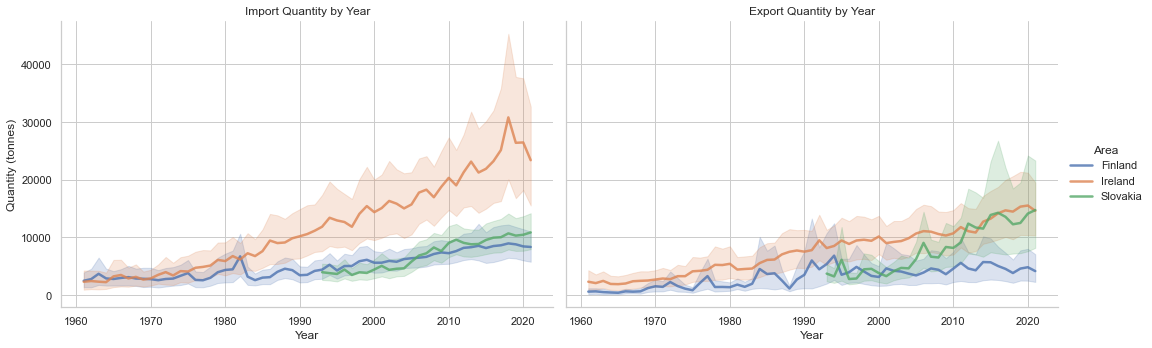

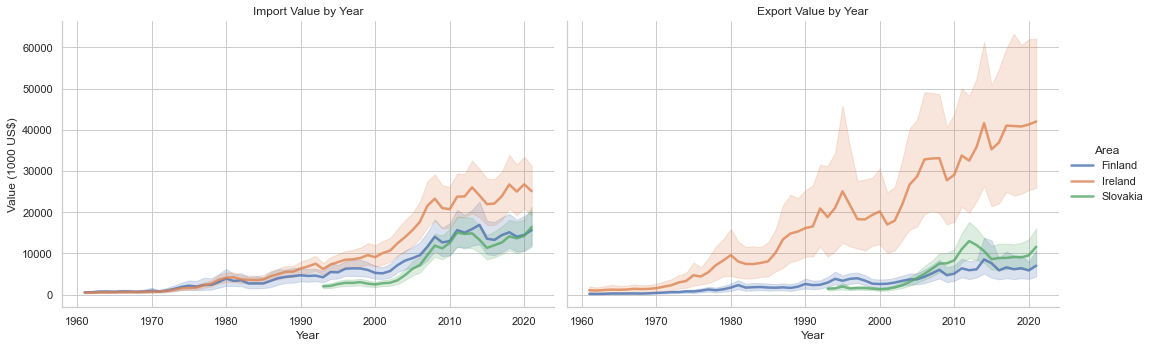

In [45]:
datasets = [im_ex_qtt_data, im_ex_val_data]
y_labels = ['Quantity (tonnes)', 'Value (1000 US$)']
idx = 0
for data in datasets:
    # create grid to display the import and export data
    im_exp_grid = sns.FacetGrid(data, col='Element', hue='Area', height=5, aspect=1.5)

    # map the above form facetgrid with some attributes  
    im_exp_grid.map(sns.lineplot, "Year", "Value", alpha = .8, linewidth=2.5)

    # adding legend
    im_exp_grid.add_legend()
    
    # setting labels and titles
    im_exp_grid.set_xlabels('Year')
    im_exp_grid.set_ylabels(y_labels[idx])
    im_exp_grid.set_titles('{col_name} by Year')
    idx+=1

The interactive graph below shows the import/export per item for each country. This way it is possible to compare the countries in a more granular level.

Only the top 10 items are displayed for performance reasons.

In [103]:
# getting the top 10 import items in terms of quantity in Ireland
import_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Element']=='Import Quantity']

top_10_items_ire = import_qtt_data[(import_qtt_data['Area'] == 'Ireland')].groupby(by='Item', as_index=False).mean().sort_values(by=['Value'], ascending=False, ignore_index=True).head(10)
top_10_items_ire = list(top_10_items_ire['Item'].unique())
top_10_items_ire

['Maize (corn)',
 'Wheat',
 'Cake of  soya beans',
 'Food wastes',
 'Molasses',
 'Raw milk of cattle',
 'Brewing or distilling dregs and waste',
 'Other non-alcoholic caloric beverages',
 'Bran of wheat',
 'Gluten feed and meal']

In [105]:
# getting the quantity data on the top 10 items
top_10_items_data_qtt = import_qtt_data[import_qtt_data['Item'].isin(top_10_items_ire)]
top_10_items_data_qtt

# getting the value data on the top 10 items
top_10_items_data_val = import_qtt_data[import_qtt_data['Item'].isin(top_10_items_ire)]
top_10_items_data_val

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
5650,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,39120.01,Bran of wheat,1961,1961,tonnes,0.00,A,Official figure
5651,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,39120.01,Bran of wheat,1962,1962,tonnes,0.00,A,Official figure
5652,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,39120.01,Bran of wheat,1963,1963,tonnes,0.00,A,Official figure
5653,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,39120.01,Bran of wheat,1964,1964,tonnes,0.00,A,Official figure
5654,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,39120.01,Bran of wheat,1965,1965,tonnes,0.00,A,Official figure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195072,TCL,Crops and livestock products,703,Slovakia,5610,Import Quantity,0111,Wheat,2017,2017,tonnes,25257.43,A,Official figure
195073,TCL,Crops and livestock products,703,Slovakia,5610,Import Quantity,0111,Wheat,2018,2018,tonnes,22716.14,A,Official figure
195074,TCL,Crops and livestock products,703,Slovakia,5610,Import Quantity,0111,Wheat,2019,2019,tonnes,40778.02,A,Official figure
195075,TCL,Crops and livestock products,703,Slovakia,5610,Import Quantity,0111,Wheat,2020,2020,tonnes,12842.20,A,Official figure


In [106]:
#!pip install altair
import altair as alt

input_dropdown = alt.binding_select(options=top_10_items_ire, name='Item')
select_item = alt.selection_single(
    name='Select Import Item', fields=['Item'], init={'Item': top_10_items_ire[0]},
    bind=input_dropdown)
alt.Chart(top_10_items_data_qtt).mark_point(filled=True).encode(
    alt.X('Year', scale=alt.Scale(zero=False)),
    alt.Y('Value', scale=alt.Scale(zero=False), title='Quantity (tonnes)'),
    alt.Size('Value:Q'),
    alt.Color('Area:N'),
    alt.Order('Value:Q', sort='descending'),
    tooltip='Value:N'
).add_selection(select_item).transform_filter(select_item)

alt.Chart(...)

#### Analysis

In [ ]:
# checking import/export values distribution
plotColGraph(im_ex_value_data[im_ex_value_data['Element'] == 'Import Value'].Value)
plotColGraph(im_ex_value_data[im_ex_value_data['Element'] == 'Export Value'].Value)

In [ ]:
# using shapiro test to verify if the value data is normal
isDistNormal(im_ex_value_data.Value)

In [ ]:
# checking import/export quantity distribution
plotColGraph(im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Import Quantity'].Value)
plotColGraph(im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Export Quantity'].Value)

In [ ]:
# using shapiro test to verify if the quantity data is normal
isDistNormal(im_ex_qtt_data.Value)

Since the import/export data of agricultural goods are not normally distributted, non-parametric tests will be applied.

- Comparing import/export data quantity and values among the countries.

In [ ]:
#!pip install pingouin
from pingouin import kruskal
kruskal(data=im_ex_value_data[im_ex_value_data['Element'] == 'Import Value'], dv='Value', between='Area')

In [ ]:
kruskal(data=im_ex_value_data[im_ex_value_data['Element'] == 'Export Value'], dv='Value', between='Area')

In [ ]:
kruskal(data=im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Import Quantity'], dv='Value', between='Area')

In [ ]:
kruskal(data=im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Export Quantity'], dv='Value', between='Area')

- Comparing import/export quantity and value in Ireland to assert the country's trade balance.

In [ ]:
kruskal(data=im_ex_value_data[im_ex_value_data['Area'] == 'Ireland'], dv='Value', between='Element')

In [ ]:
for y in list(im_ex_value_data['Year'].unique()):
    k = kruskal(data=im_ex_value_data[(im_ex_value_data['Area'] == 'Ireland')&(im_ex_value_data['Year'] == y)], dv='Value', between='Element')
    print(f'Year: {y}/P-value: {k["p-unc"]}')

In [ ]:
im_value_ire = im_ex_value_data[(im_ex_value_data['Element'] == 'Import Value')&(im_ex_value_data['Area'] == 'Ireland')]
im_value_fin = im_ex_value_data[(im_ex_value_data['Element'] == 'Import Value')&(im_ex_value_data['Area'] == 'Slovakia')]
stats.mannwhitneyu(im_value_ire['Value'], im_value_fin['Value'])

In [ ]:
im_value_ire = im_ex_value_data[(im_ex_value_data['Element'] == 'Import Value')&(im_ex_value_data['Area'] == 'Ireland')]
ex_value_ire = im_ex_value_data[(im_ex_value_data['Element'] == 'Export Value')&(im_ex_value_data['Area'] == 'Ireland')]
stats.mannwhitneyu(im_value_ire['Value'], ex_value_ire['Value'])

#### Results

Based on the inferential test, Ireland's import and export values are different, which suggests a trade deficit if the country imports more than exports.

### Food price inflation

FAO provides data on the food price inflation from several countries with data from 2000 up to 2022.

Finland, Norway and Ireland have about the same population according to the Word Population Review website.

In this study, the data about the food price inflation from these countries are compared using inferntial statistics tests.

#### Data Preparation

In [ ]:
# showing raw dataset
dataset = pd.read_csv('./datasets/fao-food-inflation-eu.csv', encoding='utf-8')
dataset.head()

In [ ]:
# remove null column from dataset
dataset = dataset.drop(['Note'], axis=1)

In [ ]:
isDistNormal(dataset.Value)

In [ ]:
dataset[(dataset['Area']=='Ireland')]['Year'].unique()
dataset[(dataset['Area']=='Ireland')&(dataset['Year']==2020)]

#### Analysis

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
#ax.plot(dataset[(dataset['Area']=='Ireland')&(dataset['Year']==2020)]['Value'], label='Ireland')
ax.plot(dataset[(dataset['Area']=='Slovakia')&(dataset['Year']==2020)]['Value'], label='Slovakia')
#ax.plot(x, ire, label='Ireland')
plt.legend(loc=2)

In [ ]:
plotColGraph(dataset.Value)

In [ ]:
# use wilcoxon stats test to compare inflation between countries
from scipy.stats import wilcoxon
res = wilcoxon(dataset[dataset['Area'] == 'Ireland'].Value, dataset[dataset['Area'] == 'Finland'].Value)
res

#### Results

Inflation data is different.